# Статистика, DS-поток
## Задание SP.11

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.



**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.**

Практика:
* Задача P1 &mdash; 50 баллов;
* Задача P2 &mdash; 100 баллов.

Задачи разных типов учитываются в разных рейтингах.

**Важность задач:**

* *высокая:* задачи P1, P2;

Задачи расставлены в том порядке, в котором их наиболее логично выполнять.

In [246]:
# Bot check

# HW_ID: ds_sp11
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [247]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

---
### Задача P1.

Напишите класс, реализующий линейную регрессию и ее статистические свойства в условиях гомоскедастичности.

*На лекции получен доверительный интервал уровня доверия $1-\alpha$ для $\theta_j$: $\left( \widehat{\theta_j} \pm \widehat{\sigma} \cdot \sqrt{(X^TX)^{-1}_{jj}} \cdot t_{n-d,1-\alpha/2} \right)$,*  
*а также получены критерии:*  
*о незначимости коэф-тов: $\{ \left| \frac{\widehat{\theta_j}}{\widehat{\sigma}\sqrt{(X^TX)^{-1}_{jj}}} \right| > t_{n-d,1-\alpha/2} \} $*  
*и о незначимости регрессии: $\{ \frac{(n-d)R^2}{(d-1)(1-R^2)} > f_{d-1,n-d,1-\alpha}\} $, где $R^2 = 1 - \frac{\|Y - X\widehat{\theta}\|^2}{\|Y - \overline{Y}\|^2}$*  

In [248]:
class LinearRegression:
    '''Класс, реализующий линейную регрессию c помощью МНК.'''

    def __init__(self, fit_intercept=True, alpha=0.05):
        '''
        :param fit_intercept: добавлять ли смещение(константный признак)
        :param alpha: уровень значимости критерия, (1-alpha): уровень доверия дов. интервала
        '''
        self.fit_intercept = fit_intercept
        self.alpha = alpha

    def fit(self, X, Y):
        '''Функция обучения модели. Предполагается Y = X * theta + epsilon, epsilon из N(0, sigma^2 * I_n).
        :param X: регрессор (матрица размера n x d),
        :param Y: отклик (матрица размера n x 1),
        '''
        self.n, self.d = X.shape
        if self.fit_intercept:
            X = np.hstack((np.ones((self.n, 1)), X))  # добавим константы, если нужно
        
        eps = np.eye(X.shape[1])*1e-5  # небольшая поправка, чтобы матрицы не вырождались
        self.theta = np.linalg.inv(X.T @ X + eps) @ X.T @ Y  # МНК-оценка
        self.sigma_sq = np.linalg.norm(Y - X @ self.theta)**2 / (self.n-self.d) # несмещенная оценка для sigma^2

        A = np.sqrt(self.sigma_sq * np.linalg.inv(X.T @ X + eps).diagonal())
        pm = A * sps.t(self.n-self.d).ppf(1 - self.alpha/2)
        self.conf_int = np.array([self.theta - pm, self.theta + pm]).T  # дов. интервалы для коэф-тов (матрица размера d x 2)

        self.t_stats = np.abs(self.theta / A)  # статистики критериев о незначимости коэф-тов (вектор размера d)
        self.t_pvalue = 2 * (1 - sps.t(self.n-self.d).cdf(np.abs(self.t_stats))) # p-value критериев о незначимости коэф-тов (вектор размера d)

        R_sq = 1 - ( np.linalg.norm(Y - X @ self.theta) / np.linalg.norm(Y - np.mean(Y)) )**2
        self.f_stat = (self.n-self.d)*R_sq / ((self.d-1)*(1-R_sq))  # статистики критерия о незначимости регрессии
        self.f_pvalue = 1 - sps.f.cdf(self.f_stat, self.d-1, self.n-self.d)  # p-value критерия о незначимости регрессии

        return self

    def summary(self):
        '''Таблица с инфо для каждого коэф-та (его оценка, дов. интервал, статистика критерия, p-value)'''
        print(f'Линейная регрессия на {self.d} признаках и {self.n} объектах')
        print(f'Sigma: {np.sqrt(self.sigma_sq):.5f}')
        print(f'F-статистика: {self.f_stat:.5f}, p-value: {self.f_pvalue:.5f}')  # результаты F-теста
        # Далее напечатайте таблицу, в которой для каждого коэф-та (по строкам) будут следующие столбцы:
        # оценка, границы дов. интервала (два столбца), статистика критерия, p-value
        display(pd.DataFrame({
            'Оценка коэф-та': self.theta,
            'Дов. интервал (L)': self.conf_int[:,0],
            'Дов. интервал (R)': self.conf_int[:,1],
            'Статистика критерия': self.t_stats,
            'p-value': self.t_pvalue
        }))

    def predict(self, X, type_interval=None):
        '''Предсказание отклика на новых объектах X и опционально доверительный/предсказательный интервал.
        :param X: матрица объектов размера n x d
        :param type_interval: тип дов. интервала.
            Для этого параметра возможны три варианта:
            * None - возвратить только предсказание, размер return-a: n;
            * 'confidence' - возвратить предсказание и дов. интервал для среднего отклика, размер return-a: n x 3;
            * 'prediction' - возвратить предсказание и предсказательный интервал для новых объектов, размер return-a: n x 3.
        :return y_pred: предсказание/предсказание и дов./предсказ. инт.
        '''

        self.n, self.d = X.shape
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = X @ self.theta
        eps = np.eye(X.shape[1])*1e-5  # небольшая поправка, чтобы матрицы не вырождались

        if type_interval is None:
            return y_pred
        else:
            if type_interval == 'confidence':
                pm = np.sqrt(self.sigma_sq * (1/self.n + (X @ np.linalg.inv(X.T @ X + eps) @ X.T).diagonal())) * sps.t(self.n - self.d).ppf(1 - self.alpha/2)
            if type_interval == 'prediction':
                pm = np.sqrt(self.sigma_sq * (1 + (X @ np.linalg.inv(X.T @ X + eps) @ X.T).diagonal())) * sps.t(self.n - self.d).ppf(1 - self.alpha/2)
            return np.array([y_pred, y_pred-pm, y_pred+pm]).T

Примените написанный класс для данных из задания 6 курса Введение в анализ данных и напечатайте `summary`. Предварительно разделите данные на обучающую и тестовую части, выполните необходимые преобразования признаков.

Проверку применимости критериев в данной задаче выполнять не нужно.

In [249]:
df = pd.read_csv('day.csv', usecols=['temp','atemp','hum','windspeed','casual','registered','cnt'])  # оставим только числовые признаки (без дат и категориальных)
df.head(3)

,temp,atemp,hum,windspeed,casual,registered,cnt
0,0.344167,0.363625,0.805833,0.160446,331,654,985
1,0.363478,0.353739,0.696087,0.248539,131,670,801
2,0.196364,0.189405,0.437273,0.248309,120,1229,1349


In [250]:
X, y = df.drop("cnt", axis=1), df["cnt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.summary()

Линейная регрессия на 6 признаках и 584 объектах
Sigma: 0.00000
F-статистика: inf, p-value: 0.00000


,Оценка коэф-та,Дов. интервал (L),Дов. интервал (R),Статистика критерия,p-value
0,-4.690719e-10,-6.378675e-10,-3.002763e-10,5.458040e+00,7.152820e-08
1,-2.772140e-09,-3.710443e-09,-1.833836e-09,5.802701e+00,1.075971e-08
2,3.642526e-09,2.581541e-09,4.703511e-09,6.742980e+00,3.768696e-11
3,-1.285230e-10,-3.058990e-10,4.885301e-11,1.423129e+00,1.552382e-01
4,4.524736e-11,-2.799170e-10,3.704117e-10,2.733057e-01,7.847158e-01
5,1.000000e+00,1.000000e+00,1.000000e+00,4.868613e+13,0.000000e+00
6,1.000000e+00,1.000000e+00,1.000000e+00,1.049852e+14,0.000000e+00


Для объектов из тестовой части постройте
* точечные предсказания,
* доверительный интервал для среднего таргета,
* предсказательный интервал для таргета.

Посчитайте, насколько часто истинное значение таргета попадает в построенные интервалы. Можно ли как-то проинтерпретировать это число?

In [251]:
point_pred = lr.predict(X_test, type_interval=None)
confidence = lr.predict(X_test, type_interval='confidence')
prediction = lr.predict(X_test, type_interval='prediction')
print(f'Попаданий y_test в довер. интервал для среднего таргета:  {((confidence[:,1]<y_test) * (y_test<confidence[:,2])).sum()}')
print(f'Попаданий y_test в предсказательный интервал для таргета: {((prediction[:,1]<y_test) * (y_test<prediction[:,2])).sum()}')

Попаданий y_test в довер. интервал для среднего таргета:  9
Попаданий y_test в предсказательный интервал для таргета: 147


*Оба числа можно интерпретировать как уверенность в предсказаниях модели. В идеале, оба числа должны составлять 95% от размера y_test. Второе число повыше, т.к. учитывает флуктуации индивидуальных измерений*

Выберите один вещественный признак, для которого отвергается гипотеза о незначимости. Постройте еще раз модель, используя только этот признак, а также константный признак. Нарисуйте график, на котором отметьте
* точки выборки,
* точечные предсказания,
* доверительный и предсказательный интервалы.

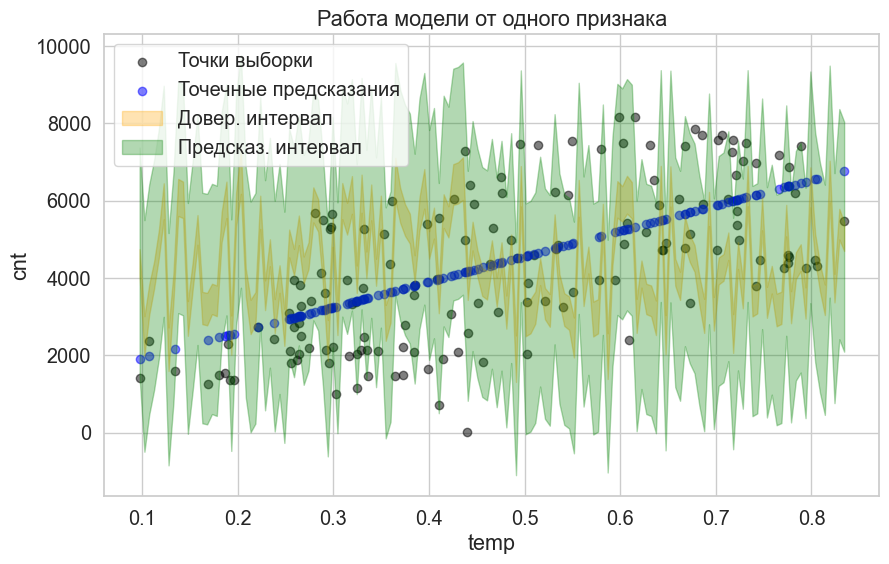

In [252]:
X, y = pd.DataFrame(df["temp"]), df["cnt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
point_pred = lr.predict(X_test, type_interval=None)
confidence = lr.predict(X_test, type_interval='confidence')
prediction = lr.predict(X_test, type_interval='prediction')

plt.figure(figsize=(10,6))
plt.title("Работа модели от одного признака")
plt.xlabel("temp")
plt.ylabel("cnt")
plt.scatter(X_test, y_test, color="black", label="Точки выборки", alpha=0.5)
plt.scatter(X_test, point_pred, color="blue", label="Точечные предсказания", alpha=0.5)
linspace = np.linspace(X_test.min()[0], X_test.max()[0], len(X_test))
plt.fill_between(linspace, confidence[:,1], confidence[:,2], color='orange', alpha=0.3, label='Довер. интервал')
plt.fill_between(linspace, prediction[:,1], prediction[:,2], color='green', alpha=0.3, label='Предсказ. интервал')
plt.legend()
plt.show()

**Выводы:**

*В этой задаче удалось ближе познакомиться со статистическими свойстами линейных моделей*

---
### Задача P2.

Рассмотрим два признака $x_1, x_2$ и целевую метку $y$.
Будем предполагать зависимость $y(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2$.
Для проверки гипотезы о *не*значимости признака $x_2$, то есть $\mathsf{H}_0\colon \theta_2=0$, на практике широко используется $T$-критерий (например, в AB-тестировании), который мы получили в предположениях гауссовской линейной модели. Проведем его исследования.

**1.** Оцените вероятность ошибки I рода в предположениях гауссовской линейной модели, в частности, **при наличии гомоскедастичности**. Для этого повторите достаточное количество раз (не менее $10^4$) следующую процедуру и усредните результаты.
1. Сгенерируйте некоторым образом выборку размера 200 из признаков $x_1$ и $x_2$.
2. Сгенерируйте целевую метку в предположениях гауссовской линейной модели. В процедуре оценки вероятности ошибки I рода на данном этапе необходимо брать $\theta_2 = 0$, то есть генерировать данные при справедливости $\mathsf{H}_0$.
3. Примените критерий.
4. Проведя достаточное количество шагов 1-3, сделайте оценку вероятности ошибки I рода и постройте соответствующий доверительный интервал.

*Примечание.* Подобную процедуру мы уже делали в предыдущих заданиях, включая построение доверительного интервала.

*Важно:* распределение данных и шума должно быть одинаковым в каждом эксперименте!

*Совет.* Используйте `tqdm` в циклах. Производите отладку кода на малом количестве итераций.

In [253]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), np.random.normal(loc=0.0, scale=1.0, size=(sample_size,2))))  # столбец единиц + выборка (нормальное)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0
    Y = X @ theta + np.random.normal(loc=0.0, scale=1.0, size=sample_size)  # добавили норм. шум
    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:14<00:00, 695.79it/s]

Оценка вероятности ош. I рода: 0.1685
Дов. интервал: [0.0000, 0.9278]


Результаты могут сильно зависеть от того, как были сгенерированы данные для эксперимента. Для надежности повторите эксперимент, как-либо иначе сгенерировав признаки. Например, для генерации можно взять другое распределение признаков.

In [254]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), sps.poisson(mu=1).rvs(size=(sample_size,2))))  # столбец единиц + выборка (Пуассон)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0
    Y = X @ theta + np.random.normal(loc=0.0, scale=1.0, size=sample_size)  # добавили норм. шум
    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка 
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

100%|██████████| 10000/10000 [00:23<00:00, 426.64it/s]

Оценка вероятности ош. I рода: 0.1669
Дов. интервал: [0.0000, 0.9221]


**2.** Повторите проведенные эксперименты **для случая гетероскедастичности**. Для этого сгенерируйте $\varepsilon_i$ из нормального распределения с дисперсией, зависящей от признаков. Например, в случае неотрицательных признаков можно взять $\mathsf{D} \varepsilon_i = \psi_0 + \psi_1 x_{i1} + \psi_2 x_{i2}$ для некоторых коэффициентов $\psi_j$.

В частности, исследуйте случаи
* $\psi_1\not=0, \psi_2=0$;
* $\psi_1=0, \psi_2\not=0$;
* $\psi_1\not=0, \psi_2\not=0$;


*Примечания.*
* Первые две ситуации разные, поскольку мы проводим исследование критериев проверки гипотезы о незначимости признака $x_2$.
* В данном случае мы применяем критерий при неверных предположениях модели, тем самым хотим исследовать поведение критерия при отклонениях от них.

In [259]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), np.random.normal(loc=0.0, scale=1.0, size=(sample_size,2))))  # столбец единиц + выборка (нормальное)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0

    psi = np.array([10, 1, 0])
    hetero = X @ psi  # гетероскедастичный шум

    Y = X @ theta + np.random.normal(loc=0.0, scale=hetero, size=sample_size)  # добавили норм. шум
    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

100%|██████████| 10000/10000 [00:14<00:00, 692.44it/s]

Оценка вероятности ош. I рода: 0.3993
Дов. интервал: [0.0028, 0.9649]


In [260]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), np.random.normal(loc=0.0, scale=1.0, size=(sample_size,2))))  # столбец единиц + выборка (нормальное)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0

    psi = np.array([10, 0, 1])
    hetero = X @ psi  # гетероскедастичный шум

    Y = X @ theta + np.random.normal(loc=0.0, scale=hetero, size=sample_size)  # добавили норм. шум
    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

100%|██████████| 10000/10000 [00:14<00:00, 670.31it/s]

Оценка вероятности ош. I рода: 0.3972
Дов. интервал: [0.0030, 0.9643]


In [261]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), np.random.normal(loc=0.0, scale=1.0, size=(sample_size,2))))  # столбец единиц + выборка (нормальное)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0

    psi = np.array([10, 1, 1])
    hetero = X @ psi  # гетероскедастичный шум

    Y = X @ theta + np.random.normal(loc=0.0, scale=hetero, size=sample_size)  # добавили норм. шум
    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

100%|██████████| 10000/10000 [00:14<00:00, 667.89it/s]

Оценка вероятности ош. I рода: 0.3980
Дов. интервал: [0.0032, 0.9671]


*При неправильном предположении (о гомоскедастичности) видно, как резко выросла ошибка*

**3.** Исследуйте, как меняется вероятность ошибки I рода при отклонении распределения шума от нормальности. В качестве распределения шума возьмите **распределение Стьюдента** с 1, 3, 5, 10 степенями свободы. Шум должен быть **гомоскедастичным**.

In [ ]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), np.random.normal(loc=0.0, scale=1.0, size=(sample_size,2))))  # столбец единиц + выборка (нормальное)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0

    Y = X @ theta + sps.t(1).rvs(size=sample_size)  # добавили шум из распр стьюдента с 1 степ

    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

100%|██████████| 10000/10000 [00:25<00:00, 394.63it/s]

Оценка вероятности ош. I рода: 0.4265
Дов. интервал: [0.0031, 0.9675]


In [263]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), np.random.normal(loc=0.0, scale=1.0, size=(sample_size,2))))  # столбец единиц + выборка (нормальное)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0

    Y = X @ theta + sps.t(3).rvs(size=sample_size)  # добавили шум из распр стьюдента с 3 степ

    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

100%|██████████| 10000/10000 [00:25<00:00, 394.02it/s]


Оценка вероятности ош. I рода: 0.1695
Дов. интервал: [0.0000, 0.9257]


In [264]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), np.random.normal(loc=0.0, scale=1.0, size=(sample_size,2))))  # столбец единиц + выборка (нормальное)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0

    Y = X @ theta + sps.t(5).rvs(size=sample_size)  # добавили шум из распр стьюдента с 5 степ

    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

100%|██████████| 10000/10000 [00:24<00:00, 400.68it/s]

Оценка вероятности ош. I рода: 0.1668
Дов. интервал: [0.0000, 0.9248]


In [265]:
sample_size, alpha = 200, 0.05
p_values = []

for _ in tqdm(range(10000)):
    X = np.column_stack((np.ones(sample_size), np.random.normal(loc=0.0, scale=1.0, size=(sample_size,2))))  # столбец единиц + выборка (нормальное)
    theta =  np.array([1, 0.5, 0])  # theta_2 = 0

    Y = X @ theta + sps.t(10).rvs(size=sample_size)  # добавили шум из распр стьюдента с 10 степ

    theta_hat = np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5) @ X.T @ Y  # МНК-оценка
    sigma_sq = np.linalg.norm(Y - X @ theta_hat)**2 / (sample_size-X.shape[1]) # несмещенная оценка для sigma^2
    t_stats = np.abs(theta_hat / np.sqrt(sigma_sq * np.linalg.inv(X.T @ X + np.eye(X.shape[1])*1e-5).diagonal()))  # статистика
    p_values.append(2 * (1 - sps.t(sample_size-X.shape[1]).cdf(np.abs(t_stats))))  # p-value

p_values = np.array(p_values)
P_I = np.mean(p_values)  # ош. I рода
print(f"Оценка вероятности ош. I рода: {P_I:.4f}")
print(f"Дов. интервал: [{np.percentile(p_values, 100*alpha/2):.4f}, {np.percentile(p_values, 100*(1-alpha/2)):.4f}]")

100%|██████████| 10000/10000 [00:26<00:00, 376.28it/s]

Оценка вероятности ош. I рода: 0.1682
Дов. интервал: [0.0000, 0.9254]


*Распределение Стьюдента стремится к нормальному с ростом числа степеней свободы. Это значит, что наше предположение о нормальности шума становится все более правильным, из-за чего ошибка падает*

**4.** Оцените и визуализируйте мощность критерия в зависимости от истинного значения $\theta_2$. Для сравнения используйте гомоскедастичный шум из нормального распределения и распределения Стьюдента с рассмотренными ранее значениями степени свободы.

**Вывод:**

*В этой задаче удалось исследовать особенности гомоскедастичного шума и его влияние на гаусс. модель*